In [343]:
%matplotlib notebook  
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output
import helpers
from helpers import conn, db_to_dataframe
from sklearn.preprocessing import StandardScaler
import talib
from tforce_env import BitcoinEnv

<IPython.core.display.Javascript object>


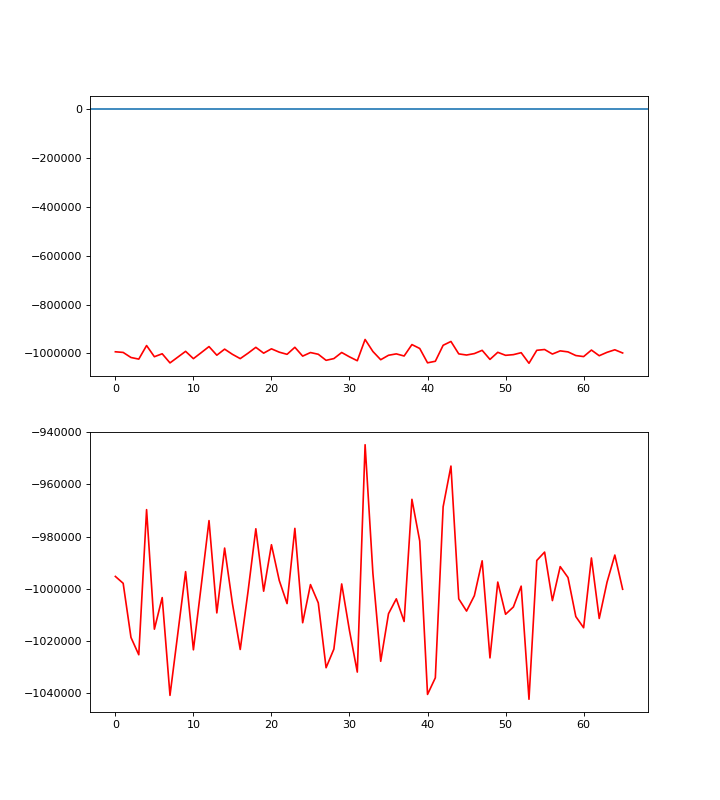

In [449]:
"""
Plot how these runs are doing. Run this cell each time you want to check
"""

data = dict(
    #b="A3C|VPG|L150L150",
    r="PPOAgent",
    #g="VPGAgent",
)

queries = {}
for k, v in data.items():
    queries[k] = """
    select reward, cash+value as total 
    from episodes 
    where agent_name='{}' 
    order by episode asc
    --limit 100
    offset 6
    """.format(v)

fig = plt.figure(figsize=(9,10))
ax_total = fig.add_subplot(211)
ax_reward = fig.add_subplot(212)
#plt.ion()

fig.show()
fig.canvas.draw()

def prep(arr, period=None):
    if not period: return arr
    return [np.mean(arr[i-period:i]) for i,v in enumerate(arr)]
    #return talib.SMA(arr.values, timeperiod=period)
    
def draw():
    dfs = {}
    for k, v in queries.items(): 
        dfs[k] = pd.read_sql_query(v, conn)
    ax_total.clear(); ax_reward.clear()
    rewards, totals = [], []
    for k, v in dfs.items():
        rewards += [prep(v['reward']), k]  # [arr, 'b']
        totals += [prep(v['total']), k]
    ax_reward.plot(*rewards)
    ax_total.plot(*totals)
    ax_total.axhline(y=2000)
    #ax_total.set_ylim([1950,2030])
    fig.canvas.draw()
    #ax_reward.set_ylim([-3000000,1000])
    
draw()
#while True:
#    draw()
#    time.sleep(10)

<IPython.core.display.Javascript object>


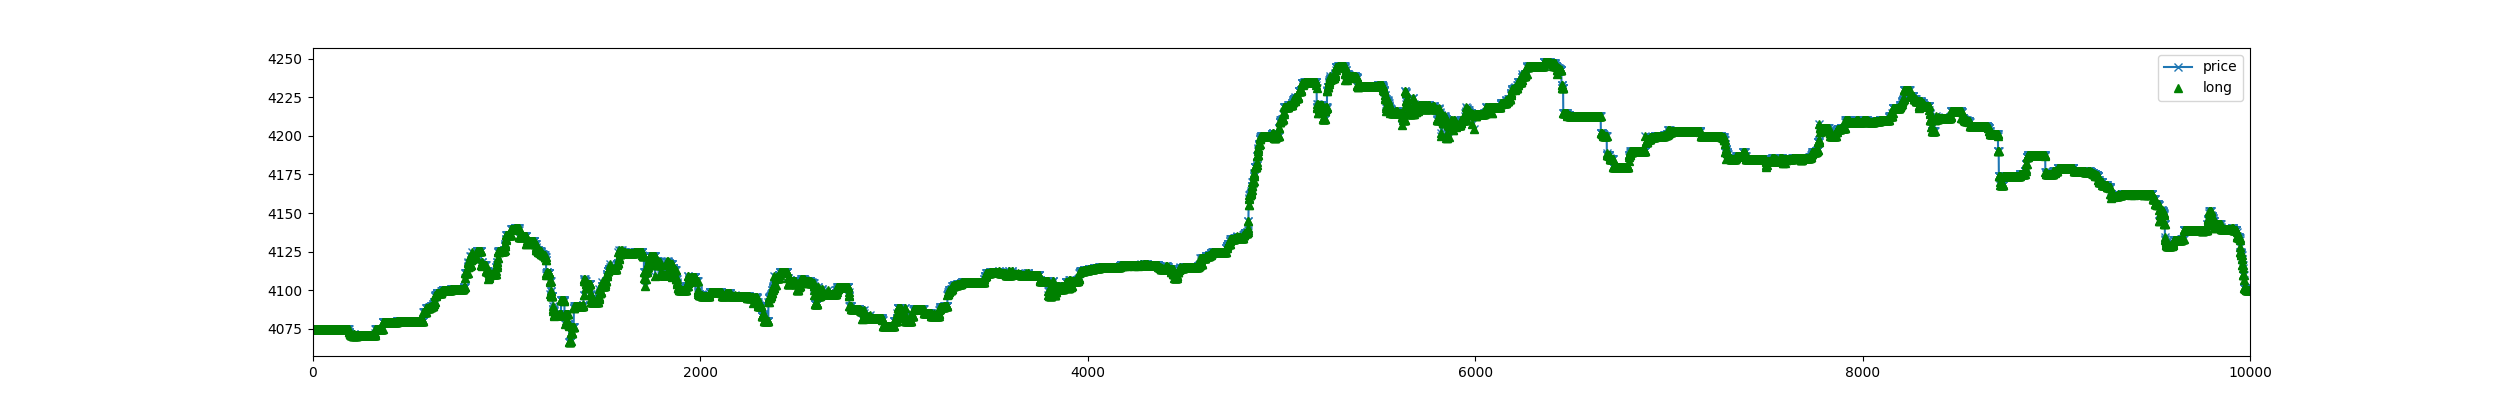

0       0.0
9999    0.0
dtype: float64


In [376]:
"""
Plot a sample of trades made by a successful run
"""
from matplotlib import cm
from tradingWithPython.lib.backtest import Backtest
rows = conn.execute("""
    select y, signals from episodes 
    where agent_name='PPOAgent' and signals is not null 
    order by episode desc limit 1
""").fetchall()
y, signals = rows[0]
p, signals = pd.Series(y[:]), pd.Series(signals[:])
fig = plt.figure(figsize=(25, 4))

print(signals[signals <= 0])

MIN = 5
l = ['price']    
p.plot(style='x-')
             
# # --- plot trades
# #colored line for long positions
idx = (signals > MIN)
if idx.any():
    p[idx].plot(style='g^')
    l.append('long')

# #colored line for short positions    
idx = (signals < -MIN)
if idx.any():
    p[idx].plot(style='rv')
    l.append('short')

plt.xlim([p.index[0],p.index[-1]]) # show full axis
plt.legend(l,loc='best')  

#print('PNL:{}'.format(bt.pnl.iloc[-1]))
#fig.canvas.draw()
plt.show()

In [278]:
"""
Again but with Backtrader https://www.backtrader.com/docu/quickstart/quickstart.html
"""
import backtrader as bt
rows = conn.execute("""
    select y, signals from episodes 
    where agent_name='A3C|VPG|D150L150L510' and signals is not null 
    order by episode desc limit 1
""").fetchall()
y, signals = rows[0]
i = 0
class TestStrategy(bt.Strategy):
    def next(self):
        global signals, i
        sig = signals[i]; i += 1
        if sig > 1: self.buy(sig)
        elif sig < 1: self.sell(sig)

cerebro = bt.Cerebro()
cerebro.addstrategy(TestStrategy)
cerebro.adddata(bt.feeds.PandasData(dataname=y))
cerebro.broker.setcash(2000) # set value somewhere?
cerebro.broker.setcommission(commission=.0025)
cerebro.run()

IndexError: list index out of range

In [345]:
"""
Scratch-pad
"""
env = BitcoinEnv(agent_type='PPOAgent')
env.scale_features_and_save()

AttributeError: 'BitcoinEnv' object has no attribute 'scale_features_and_save'

In [339]:
btc_env = BitcoinEnv(agent_type='PPOAgent')
scaler.transform([[0,1,2,3,4,5,6,7,8,9]])[0]

array([-26.44746834, -25.30700535, -22.97629606,  -3.07710202,
       -16.3966246 , -16.70055501, -14.64406958,  -2.97251726,
        -1.71999107,  -1.71003122])